<a href="https://colab.research.google.com/github/t-zakharenko/ML-course-May-2025/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_TZ_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.getcwd())

/content


Area under ROC score on Train dataset: 0.75%


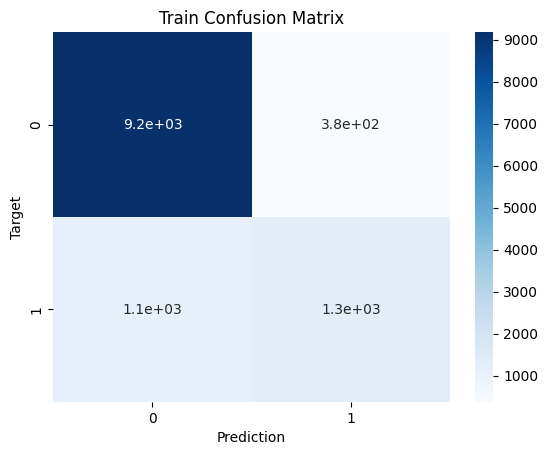

Area under ROC score on Validation dataset: 0.76%


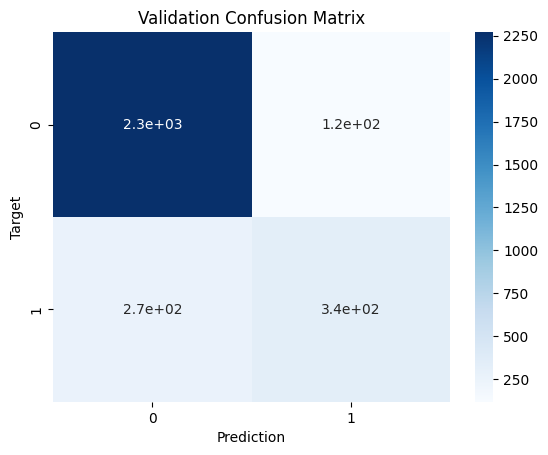

['log_reg_pipeline.joblib']

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


raw_df = pd.read_csv('train.csv', index_col=0)

train_df, val_df = train_test_split(
    raw_df,
    test_size=0.2,
    random_state=42,
    stratify=raw_df['Exited']
)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[2:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()

train_targets = train_df[target_col]
val_targets = val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes('number').columns
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])


# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'log_reg_pipeline.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train (Poly) dataset: 0.79%


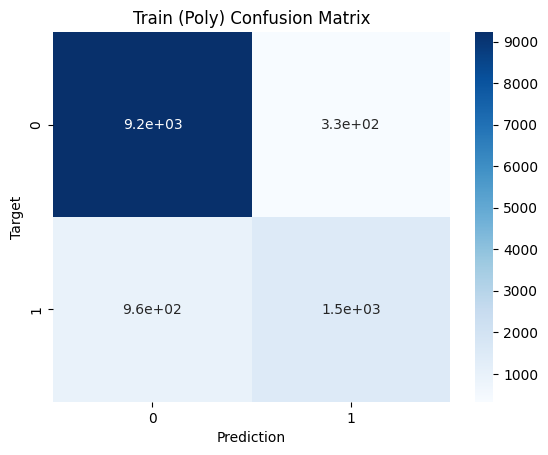

Area under ROC score on Validation (Poly) dataset: 0.79%


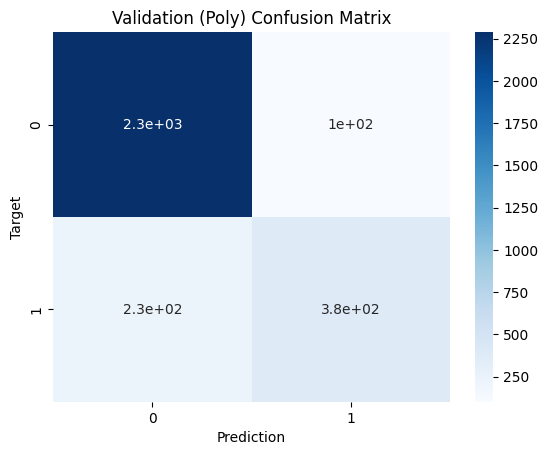

In [5]:
from sklearn.preprocessing import PolynomialFeatures

# Створюємо трансформер для числових колонок
numeric_poly_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_poly_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_poly.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Train (Poly)')
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation (Poly)')


**Висновок**
Модель із додаванням поліноміальних ознак 2-го стуеню продемонструвала покращення AUROC як на тренувальному (з 0.75 до 0.79), так і на валідаційному наборі (з 0.76 до 0.79). Це свідчить про те, що модель краще описує нелінійні залежності між ознаками.

Модель не має ознак недонавчання (underfit) чи переобучення (overfit), оскільки якість передбачення на валідаційних даних є  співпадає з тренувальними.

Можна зробити висновок, що модель добре генералізує на нових даних.


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train (Poly) dataset: 0.82%


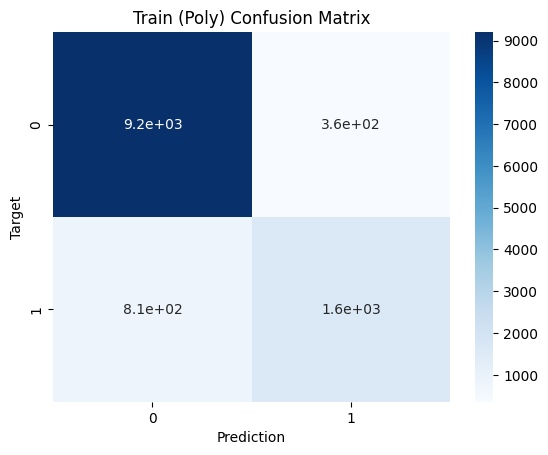

Area under ROC score on Validation (Poly) dataset: 0.81%


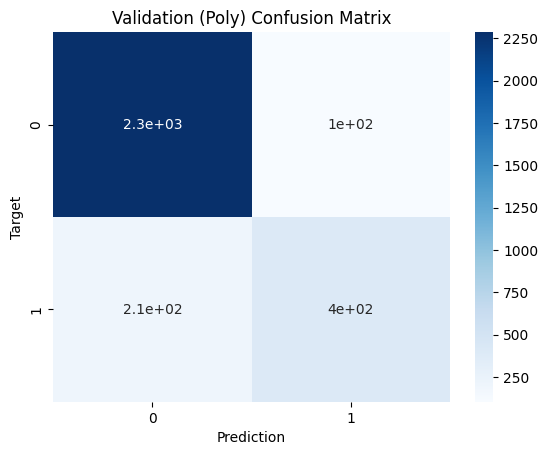

In [6]:
# Створюємо трансформер для числових колонок
numeric_poly_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4, include_bias=False))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_poly_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_poly.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Train (Poly)')
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation (Poly)')

**Висновок**

Додавання поліноміальних ознак до 4-го степеня дало покращення як на тренувальних, так і на валідаційних даних.
Overfitting не спостерігається: різниця між train і validation ROC AUC мала.
Модель добре генералізує, я буду робити submittion на на змагання Kaggle.

In [7]:
test_raw_df = pd.read_csv('test.csv')
test_probs = model_pipeline_poly.predict_proba(test_raw_df)[:, 1]
test_raw_df['Exited'] = (test_probs >= 0.5).astype(int)

submission_df = pd.read_csv('sample_submission.csv')
submission_df['Exited'] = test_raw_df['Exited'].values

submission_df.to_csv('submission_poly_deg4.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [8]:
from sklearn.linear_model import LinearRegression


raw_df = pd.read_csv('regression_data.csv')

train_df, test_df = train_test_split(
    raw_df,
    test_size=0.2,
    random_state=42
)

# Створюємо трен. і test. набори
input_cols = list(train_df.columns)[0:-1]
target_col = 'target'

train_inputs = train_df[input_cols].copy()
test_inputs = test_df[input_cols].copy()

train_targets = train_df[target_col]
test_targets = test_df[target_col]


scaler = MinMaxScaler()
scaler.fit(train_inputs[input_cols])

train_inputs[input_cols] = scaler.transform(train_inputs[input_cols])
test_inputs[input_cols] = scaler.transform(test_inputs[input_cols])


In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(train_inputs)

model = LinearRegression()

X_train_poly = poly.transform(train_inputs)
X_test_poly = poly.transform(test_inputs)

model.fit(X_train_poly, train_targets)

train_preds = model.predict(X_train_poly)
test_preds = model.predict(X_test_poly)

In [16]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_targets, train_preds)
test_mse = mean_squared_error(test_targets, test_preds)

print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")



Train MSE: 0.00
Test MSE: 300.98


**Висновок**
Модель лінійної регресії з поліноміальними ознаками до ступеня 5 має нульову (або близьку до нульової) помилку на тренувальних даних (Train MSE ≈ 0.00), але значно гірший результат на тестових (Test MSE ≈ 301). Це свідчить про перенавчання моделі(overfitting). Модель дуже погано генералізує.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [27]:
from sklearn.linear_model import Lasso

poly_20 = PolynomialFeatures(degree=20, include_bias=False)
poly_20.fit(train_inputs)

model_Lasso = Lasso(alpha=0.1)

X_train_poly_20 = poly_20.transform(train_inputs)
X_test_poly_20 = poly_20.transform(test_inputs)

model_Lasso.fit(X_train_poly_20, train_targets)

train_preds_Lasso = model_Lasso.predict(X_train_poly_20)
test_preds_Lasso = model_Lasso.predict(X_test_poly_20)

In [23]:
from sklearn.linear_model import Ridge

model_Ridge = Ridge()
model_Ridge.fit(X_train_poly_20, train_targets)

train_preds_Ridge = model_Ridge.predict(X_train_poly_20)
test_preds_Ridge = model_Ridge.predict(X_test_poly_20)


In [30]:
from sklearn.metrics import mean_squared_error, r2_score

#  Lasso
train_mse_lasso = mean_squared_error(train_targets, train_preds_Lasso)
test_mse_lasso = mean_squared_error(test_targets, test_preds_Lasso)

train_r2_lasso = r2_score(train_targets, train_preds_Lasso)
test_r2_lasso = r2_score(test_targets, test_preds_Lasso)

print("\n-----------LASSO-------------")
print(f"Train MSE: {train_mse_lasso:.4f} | Test MSE: {test_mse_lasso:.4f}")
print(f"Train R2: {train_r2_lasso:.4f} | Test R2: {test_r2_lasso:.4f}")

#  Ridge
train_mse_ridge = mean_squared_error(train_targets, train_preds_Ridge)
test_mse_ridge = mean_squared_error(test_targets, test_preds_Ridge)

train_r2_ridge = r2_score(train_targets, train_preds_Ridge)
test_r2_ridge = r2_score(test_targets, test_preds_Ridge)

print("\n-----------RIDGE-------------")
print(f"Train MSE (ElasticNet): {train_mse_ridge:.4f} | Test MSE: {test_mse_ridge:.4f}")
print(f"Train R2 (ElasticNet): {train_r2_ridge:.4f} | Test R2: {test_r2_ridge:.4f}")

#  ElasticNet
train_mse_elastic = mean_squared_error(train_targets, train_preds_ElasticNet)
test_mse_elastic = mean_squared_error(test_targets, test_preds_ElasticNet)

train_r2_elastic = r2_score(train_targets, train_preds_ElasticNet)
test_r2_elastic = r2_score(test_targets, test_preds_ElasticNet)

print("\n-----------ELASTIC NET-------------")
print(f"Train MSE (ElasticNet): {train_mse_elastic:.4f} | Test MSE: {test_mse_elastic:.4f}")
print(f"Train R2 (ElasticNet): {train_r2_elastic:.4f} | Test R2: {test_r2_elastic:.4f}")



-----------LASSO-------------
Train MSE: 1.4366 | Test MSE: 1.0092
Train R2: 0.9993 | Test R2: 0.9996

-----------RIDGE-------------
Train MSE (ElasticNet): 34.6340 | Test MSE: 49.2951
Train R2 (ElasticNet): 0.9822 | Test R2: 0.9789

-----------ELASTIC NET-------------
Train MSE (ElasticNet): 153.9924 | Test MSE: 142.8386
Train R2 (ElasticNet): 0.9209 | Test R2: 0.9388


In [35]:

print("Кількість ненульових коефіцієнтів:")

print(f"Lasso:       {(model_Lasso.coef_ != 0).sum()} / {len(model_Lasso.coef_)}")
print(f"Ridge:       {(model_Ridge.coef_ != 0).sum()} / {len(model_Ridge.coef_)}")
print(f"ElasticNet:  {(model_ElasticNet.coef_ != 0).sum()} / {len(model_ElasticNet.coef_)}")


Кількість ненульових коефіцієнтів:
Lasso:       1 / 53129
Ridge:       53129 / 53129
ElasticNet:  409 / 53129


**Висновок**

Найкраще генералізує модель Lasso.
Вона забезпечила найкращі метрики на тесті (MSE ≈ 1) та обрала лише одну важливу ознаку — feature_4, що свідчить про простоту моделі та високу здатність до узагальнення.

Я також провела додатковий аналіз ознак і побачила майже ідеальну лінійну залежність між feature_4 і цільовою змінною. Цей результат ще раз підкреслює, як важливо розуміти свої дані, будувати візуалізації та досліджувати структуру ознак — це допомагає не тільки обрати правильну модель, а й пояснити її поведінку.